# Deep portfolio Optimization

In [1]:
import numpy as np
from random import choice
from scipy.linalg import cholesky
from scipy.linalg import lu

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, Concatenate, Dropout, Subtract, \
                        Flatten, MaxPooling2D, Multiply, Lambda, Add, Dot
from tensorflow.keras.backend import constant
from tensorflow.keras import optimizers

from tensorflow.keras import Model
from tensorflow.keras import Input
from tensorflow.keras import initializers
from tensorflow.keras.constraints import max_norm
import tensorflow.keras.backend as K

import matplotlib.pyplot as plt


In [2]:
# Trajectories of the Black scholes model
# Let it run to initialize the following parameters, the trajectories 
# are not needed afterwards

N = 30 # time disrectization
S0 = 1 # initial value of the asset
X0 = 1  # initial wealth
T = 1 # maturity
sigma = 0.2 # volatility in Black Scholes
mu = 0.1
r = 0.0
gamma = 0
rho = 0
uncertainty = 0.3


# def r_t(alpha):
#     y = tf.constant([1],dtype=tf.float32)
#     if(tf.math.less(alpha,y)):
#         return r
#     else:
#         interest = Lambda(lambda x : (mu-r)*x+2*r-mu)(alpha)
# #         interest = (mu-r)*alpha+2*r-mu
#         return interest


In [3]:
# tmp = np.matrix([np.random.randn(n) + np.random.randn(1)*a for i in range(n)])
# tmp2 = tmp * np.transpose(tmp)
# tmp_half = np.diag(np.diag(tmp2)**(-0.5))
# tmpC = tmp_half*tmp2*tmp_half
# tmp_vals = list(np.array(tmpC.ravel())[0])

# print(tmpC)
# print()
# print(tmp_vals)
# print()
# print(np.linalg.eig(tmpC)[0])

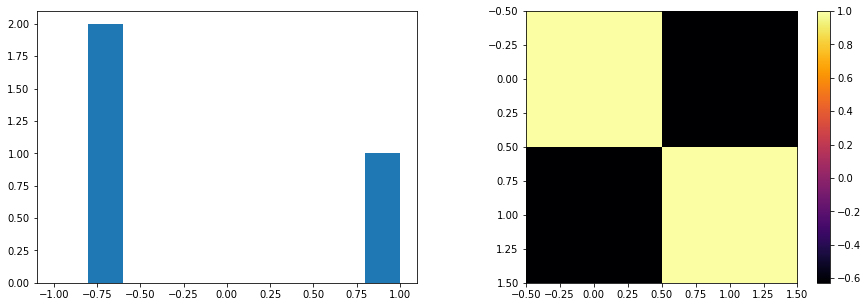

In [4]:
# import numpy as np
# from random import choice
# import matplotlib.pyplot as plt
# from scipy.linalg import cholesky
# from scipy.linalg import lu

n = 2 # number of assets?
a = 0 # what is this for?
# random_sigma = 1
# random_mean = 0

# np.random.randn(n) returns a n length list of random standard normal random numbers
# could use reparametrisation trick here to generate entries with distribution of N(random_mean, random_sigma^2)
A = np.matrix([np.random.randn(n) + np.random.randn(1)*a for i in range(n)])
A = A * np.transpose(A) # make A symmetric
D_half = np.diag(np.diag(A)**(-0.5))
# what are we using C for? C is the rho aka correlation matrix
# C is hermitian and positive definite
C = D_half*A*D_half # norm diagonals, why are we doing this?


# plotting
vals = list(np.array(C.ravel())[0])

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axes[0].hist(vals, range=(-1,1))
img = axes[1].imshow(C, interpolation=None,cmap = 'inferno')
plt.colorbar(img, ax=axes[1])
plt.show()

[[ 1.         -0.62726146]
 [ 0.          0.77880875]]
(1000, 2)
[1.10531927 1.09775821]


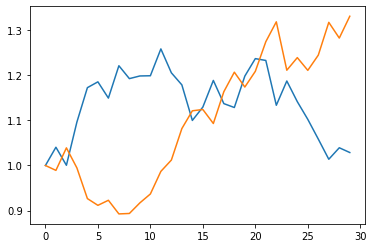

In [5]:
# C = R*R.T, where R is an unitary matrix (as C is hermitian and positive definite)
R = cholesky(C)
print(R)

mu_vec = np.ones(n) * mu
sigma_vec = np.ones(n) * sigma

avg = []
for j in range(1000):
    logS = np.zeros((n,N))
    logS[:,0] = np.log(S0) * np.ones(n)

    for i in range(N-1):
        corr_gbm = np.random.normal(0, np.sqrt(T)/np.sqrt(N), size=(1,n))
        # Why are we doing this? make the gbms correlate with each other
        corr_gbm = np.matmul(corr_gbm, R)
        # BM term
        increment = [a*b for a,b in zip(corr_gbm, sigma_vec)]
        # Where does this formula come from? this is the dt
        increment = increment + mu_vec * T / N - 0.5 * (sigma_vec)**2 * T / N
        increment = np.reshape(increment, n)
#         increment = np.squeeze(increment)
        logS[:,i+1] = logS[:,i] + increment
    
    avg.append(np.exp(logS[:,-1]))

print(np.shape(avg))
average = np.mean(avg, axis=0)
print(average) 

# plotting
S = np.exp(logS)
for i in range(n):
    plt.plot(S[i,:])

In [6]:
# # this overwrites C and R from above

# # note n = m
# m = 2
# # Why are we choosing another C here? (in contrast to above)
# C = np.array([[1, 0], [0, 1]])
# R = cholesky(C)
# sigma_vec = np.ones(m) * sigma
# mu_vec = np.ones(m) * mu
# print(R)

[[1. 0.]
 [0. 1.]]


In [7]:
### m stocks with same parameters ###

m = 2 # dimension of price
d = 3 # number of layers in strategy
number_of_nodes = 32  # nodes in the first but last layers

# architecture is the same for all networks
layers = []
for j in range(N):
    for i in range(d):
        if i < d-1:
            nodes = number_of_nodes
            layer = Dense(nodes, activation='tanh', trainable=True,
                          kernel_initializer=initializers.RandomNormal(0,0.5),#kernel_initializer='random_normal',
                          bias_initializer=initializers.RandomNormal(0,0.5),
                          name=str(i)+str(j))
#             layers.append(layer)
        else:
            nodes = m
            layer = Dense(nodes, activation='linear', trainable=True,
                          kernel_initializer=initializers.RandomNormal(0,0.5),#kernel_initializer='random_normal',
                          bias_initializer=initializers.RandomNormal(0,0.5),
                          name=str(i)+str(j))
#             layers.append(layer)
        layers = layers + [layer]

In [8]:
# Implementing the outcome of trading via neural networks
# Inputs is the training set below, containing the price S0, 
# again we record the trading strategies on separate input variables 'tradeeval' to read them out easily later
price = Input(shape=(m,))
tradeeval = Input(shape=(m,))
wealth = Input(shape=(1,))

inputs = [price] + [tradeeval] + [wealth]
outputhelper=[]
outputhelper2 = []

for j in range(N):
    incr = Input(shape=(m,))
#     strategy = price
#     strategyeval=tradeeval

    # giving the model insider information on the movement of the stocks at next timestep
    flip = Input(shape=(m,))
    insider = Lambda(lambda x: tf.math.sign(x))(incr)
    insider = Multiply()([flip, insider]) # flip the information with proba = uncertainty
    strategy = Lambda(lambda x: tf.concat(x, axis=1))([price, insider])
    strategyeval = Lambda(lambda x: tf.concat(x,axis=1))([tradeeval, insider])
                          
    for k in range(d):
        strategy = layers[k + j*d](strategy) # strategy at j is the alpha at j 
        strategyeval = layers[k + j*d](strategyeval)
        
    # implement an interest rate dependent on strategy    
    helper0a = Lambda(lambda x : K.sum(x, axis=1, keepdims=True))(strategy)
    helper0b = Lambda(lambda x: K.less(1.0, x))(helper0a)
    helper0b = Lambda(lambda x: tf.cast(x, tf.float32))(helper0b)
    r_t = Lambda(lambda x: x * (mu_vec.mean() - r) * (helper0a - 1) + r)(helper0b)
#     r_t = r
        
    # implement price increment
    temp = Lambda(lambda x : x - sigma_vec**2/2 * T/N)(incr)
    logprice = Lambda(lambda x : K.log(x))(price)
    logprice = Add()([logprice, temp])
    pricenew = Lambda(lambda x : K.exp(x))(logprice)
    price = pricenew    
    
    # implement all normal terms of logwealth
    logwealth = Lambda(lambda x : K.log(x))(wealth)
    helperR = Lambda(lambda x : x * T/N)(r_t)
    logwealth = Add()([helperR, logwealth])
    
    helper1 = Multiply()([strategy, incr])
    helper1 = Lambda(lambda x : K.sum(x, axis=1))(helper1)
    logwealth = Add()([logwealth, helper1])
    
    helper2 = Lambda(lambda x : K.sum(x, axis=1))(strategy)
    helper2b = Multiply()([r_t, helper2])
    helper2c = Lambda(lambda x : x * T/N)(helper2b)
    logwealth = Subtract()([logwealth, helper2c])
    
    #implement the rho cross terms
    helper3 = Lambda(lambda x : sigma_vec * x)(strategy) #(none,m)
    helper3t = Lambda(lambda x : K.transpose(x))(helper3) #(m,none)
    
    temp_chol = K.constant(C) #(m,m) matrix
    
    helper4 = Lambda(lambda x: K.dot(x, temp_chol))(helper3) #(none,m)*(m,m) = (none,m)
    helper4 = Lambda(lambda x: tf.einsum('ij,ji->i',x[0], x[1]))([helper4, helper3t]) #(none,m)*(m,none) = (none,none)
    #take only the diag of the (none,none) matrix = (none,)
    ### tf.einsum explanation
    # C[i,k] = sum_j A[i,j] * B[j,k] ==> 'ij,jk->ik'
    # source: https://www.tensorflow.org/api_docs/python/tf/einsum
    
    helper5 = Lambda(lambda x: 1/2*x * T/N)(helper4)
    logwealth = Subtract()([logwealth, helper5])
    
    wealthnew = Lambda(lambda x: K.exp(x))(logwealth)# creating the wealth at time j+1
    inputs += [incr] + [flip]
    outputhelper += [r_t] + [strategy] # here we collect the strategies
    wealth = wealthnew

outputs = wealth
outputs = [outputs] + outputhelper
outputs = Concatenate()(outputs)

model_Merton_n = Model(inputs=inputs, outputs=outputs)

In [33]:
model_Merton_n.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 2)            0           input_4[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 2)]          0                                            
______________________________________________________________________________________________

__________________________________________________________________________________________________
lambda_281 (Lambda)             (None, 2)            0           lambda_261[0][0]                 
__________________________________________________________________________________________________
lambda_280 (Lambda)             (None, 2)            0           input_30[0][0]                   
__________________________________________________________________________________________________
input_32 (InputLayer)           [(None, 2)]          0                                            
__________________________________________________________________________________________________
213 (Dense)                     (None, 2)            66          113[0][0]                        
__________________________________________________________________________________________________
add_37 (Add)                    (None, 1)            0           lambda_263[0][0]                 
          

lambda_403 (Lambda)             (None, 1)            0           lambda_402[0][0]                 
__________________________________________________________________________________________________
subtract_36 (Subtract)          (None, 1)            0           add_56[0][0]                     
                                                                 lambda_392[0][0]                 
__________________________________________________________________________________________________
lambda_397 (Lambda)             (None,)              0           lambda_396[0][0]                 
__________________________________________________________________________________________________
lambda_421 (Lambda)             (None, 4)            0           lambda_408[0][0]                 
                                                                 multiply_60[0][0]                
__________________________________________________________________________________________________
lambda_404

In [13]:
Ktrain = 10**5
initialprice = S0
initialwealth = X0

m = 2
uncorr = [np.random.normal(0,np.sqrt(T)/np.sqrt(N),(Ktrain,m)) for i in range(N)]
corr = []
for unc in uncorr:
    corr.append(unc@R*sigma+mu*T/N)
    corr.append(np.random.choice([-1,1],size=(Ktrain,m),p=[uncertainty,1-uncertainty]))

xtrain = ([initialprice*np.ones((Ktrain,m))] +
#           [np.zeros((Ktrain,m))]+
          [1*np.ones((Ktrain,m))] +
          [initialwealth*np.ones((Ktrain,1))] +
                 corr)
#           [np.random.normal(mu*T/N,sigma*np.sqrt(T)/np.sqrt(N),(Ktrain,m)) for i in range(N)])

ytrain=np.zeros((Ktrain,1+N))

In [14]:
def custom_loss(y_true,y_pred):
    z = - K.log(y_pred[:,0])
#     z = -(y_pred[:,0]**gamma-1)/gamma
    z=K.mean(z)
    return z
#def custom_loss(y_true,y_pred):
#    z = K.exp(- y_pred[:,0]*ra)#
#    z=K.mean(z)
#    return z


In [18]:


adam=optimizers.Adam(lr=0.01)

# model_Merton_n.compile(optimizer='adam',loss=custom_loss)
model_Merton_n.compile(optimizer='adam',loss=custom_loss,experimental_run_tf_function=False)

In [19]:


for i in range(1):
    model_Merton_n.fit(x=xtrain,y=ytrain, epochs=1,verbose=True,batch_size=100)

Train on 100000 samples
100000/100000 [==============================] - 37s 368us/sample - loss: -1.9530


In [20]:
y_pred = model_Merton_n.predict(xtrain)

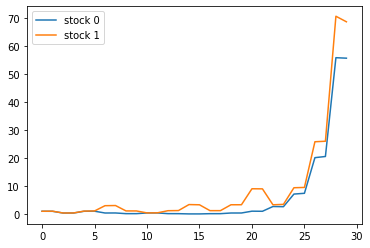

In [21]:
logS= np.zeros((m,N))
logS[:,0]=np.log(S0)*np.ones(m)
for i in range(N-1):
        incr = xtrain[3+i][0]
        increment = incr -sigma_vec**2/2*T/N
        increment = np.reshape(increment, m)
        logS[:,i+1] =logS[:,i]+increment
S=np.exp(logS)
for i in range(m):
    plt.plot(S[i,:],label='stock '+str(i))
plt.legend()
plt.show()

In [22]:
k = 0
info = y_pred[k]
print('y_pred shape:      ', y_pred.shape)
print('final wealth:      ', info[0])
interest = list(info[1+i*3] for i in range(30))
print('r:                 ', interest[0:5])
alpha1 = list(info[2+i*3] for i in range(30))
print('alpha for stock 1: ', alpha1[0:5])
alpha2 = list(info[3+i*3] for i in range(30))
print('alpha for stock 2: ', alpha2[0:5])
temp = np.array(xtrain[3:8])
print('stock 1 increment: ', temp[0:5,k,0])
print('stock 2 increment: ', temp[0:5,k,1])

#final wealth under 1
temp = y_pred[:,0]
temp = temp[temp<1]
print('number of final wealths under 1: ',len(temp))

y_pred shape:       (100000, 91)
final wealth:       56.08786
r:                  [-0.0, 0.16458893, 0.039781, -0.0, 0.20437081]
alpha for stock 1:  [9.150434, 0.7997171, -8.137765, -6.4106483, 0.8997353]
alpha for stock 2:  [-8.213442, 1.8461721, 9.535575, -6.7688746, 2.1439729]
stock 1 increment:  [-0.01248352 -1.          0.01013861  1.          0.02783295]
stock 2 increment:  [ 0.02548062 -1.          0.02729353  1.          0.04572893]
number of final wealths under 1:  12275


In [26]:
temp_std = y_pred[:,0].std()
# temp_std = temp_std[temp_std<1]
# print('number of final wealths under 1: ',len(temp_std))
print(temp_std)

249.06158


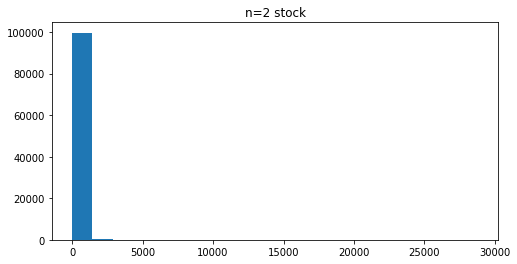

avg final wealth for one stock:  50.056095
standard deviation of final wealth for n=2 stock:  249.06158


In [27]:
fig, axs = plt.subplots(nrows=1, ncols=1)
   ...: axs.hist(y_pred[:,0], bins=20)
    
axs.title.set_text('n=2 stock')

fig.set_size_inches(8, 4)
plt.show()

print('avg final wealth for one stock: ', np.mean(y_pred[:,0]))
print('standard deviation of final wealth for n=2 stock: ', np.std(y_pred[:,0]))

In [28]:
k=10#Choose a number between 1 and N-1
Ktest=60
xtest = ([initialprice*np.ones((Ktest,m))] +
          [np.zeros((Ktest,m))]+
          [np.linspace(0.7,1.5,Ktest)] +#change this if you go to higher dimensions
          [initialwealth*np.ones((Ktest,m))]+
          [np.random.normal(mu*T/N,sigma*np.sqrt(T)/np.sqrt(N),(Ktest,m)) for i in range(N)])


In [31]:
#Comparison of learned and true alpha
s=np.linspace(0.7,1.5,Ktest)

for k in range(1,N):
    truestrat=(mu-r)/(sigma**2*(1-gamma))*np.ones(Ktest)
    learnedstrat=model_Merton_n.predict(xtest)[:,k]
    plt.plot(s,learnedstrat,s,truestrat)
plt.show()
print((mu-r)/(sigma**2*(1-gamma)))

ValueError: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 63 array(s), for inputs ['input_1', 'input_2', 'input_3', 'input_4', 'input_5', 'input_6', 'input_7', 'input_8', 'input_9', 'input_10', 'input_11', 'input_12', 'input_13', 'input_14', 'input_15', 'input_16', 'input_17', 'input_18', 'input_19', 'input_20', 'input_21', 'input_22', 'input_23', 'input_24', 'input_25', 'input_26', 'input_27', 'input_28', 'input_29', 'input_30', 'input_31', 'input_32', 'input_33', 'input_34', 'input_35', 'input_36', 'input_37', 'input_38', 'input_39', 'input_40', 'input_41', 'input_42', 'input_43', 'input_44', 'input_45', 'input_46', 'input_47', 'input_48', 'input_49', 'input_50', 'input_51', 'input_52', 'input_53', 'input_54', 'input_55', 'input_56', 'input_57', 'input_58', 'input_59', 'input_60', 'input_61', 'input_62', 'input_63'] but instead got the following list of 34 arrays: [array([[1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., ...